In [1]:
# import all libraries 
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.manifold import TSNE
import random
import warnings
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score
import community.community_louvain as comm_cl
warnings.filterwarnings('ignore')
%run ./helper.ipynb

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def node_classification(embeddings, label):
    X, Y = read_node_label(label,skip_head=True)
    
    ltrainfrac = [0.05, 0.1, 0.2, 0.3, .4, .5, .6, .7, .8]
    for tf in ltrainfrac:
        print("Training classifier using {:.2f}% nodes...".format(tf * 100))
        split_train_evaluate(X, Y, embeddings, tf)


        
        
def makeLinkPredictionData(graph, embeddings):
    # converting embedding to a numpy array
    X = [[0] for i in range(G.number_of_nodes())]
    for i in range(0, G.number_of_nodes()):
        X[i] = embeddings[str(i+1)]
    X = np.array(X)
    
    Xd = []
    Yd = []
    count = 0
    # for all vertices
    for u in range(graph.number_of_nodes()):
        Nu = list(graph.neighbors(u))
        count += len(Nu)
        cn = 0
        totalns = 0
        # for all neighbors of u
        for n in Nu:
            x = []
            if n > u:
                for d in range(len(X[0])):
                    x.append(X[u][d] - X[n][d]) # distance between the embeddings of u and its neighbor n
                Xd.append(x)
                Yd.append(1) # positive sample (edge present)
                totalns += 1
        tmpnn = []
        if len(Nu) > graph.number_of_nodes() // 2:
            totalns = (graph.number_of_nodes() - len(Nu)) // 2
            #print("Testing neighbors!")
        while cn < totalns:
            nn = random.randint(0, graph.number_of_nodes() - 1)
            # non-neighbors of u
            if nn not in Nu and nn not in tmpnn:
                cn += 1
                x = []
                for d in range(len(X[0])):
                    x.append(X[u][d] - X[nn][d])
                Xd.append(x)
                Yd.append(0) # negative sample (edge absent)
                tmpnn.append(nn)
    Xd, Yd = np.array(Xd), np.array(Yd)
    indices = np.array(range(len(Yd)))
    np.random.shuffle(indices)
    Xt = Xd[indices]
    Yt = Yd[indices]
    #print(len(Xd), len(Yd), count)
    
    
    ltrainfrac = [0.05, 0.1, 0.2, 0.3, .4, .5, .6, .7, .8]
    for tf in ltrainfrac:
        CV = int(len(Yt) * tf)
        trainX = Xt[0:CV]
        testX = Xt[CV:]
        trainY = Yt[0:CV]
        testY = Yt[CV:]
        modelLR = LogisticRegression().fit(trainX, trainY)
        predictedY = modelLR.predict(testX)
        acc = accuracy_score(predictedY, testY)
        #f1macro = f1_score(predictedY, testY, average='macro', labels=np.unique(predictedY))
        #f1micro = f1_score(predictedY, testY, average='micro', labels=np.unique(predictedY))
        #print("Link predictions:", tf, ":Accuracy:",acc, "F1-macro:", f1macro, "F1-micro:",f1micro)
        print("Link predictions:", tf, ":Accuracy:",acc)



def cluster_eval(G, embeddings):
    # converting embedding to a numpy array
    X = [[0] for i in range(G.number_of_nodes())]
    for i in range(0, G.number_of_nodes()):
        X[i] = embeddings[str(i+1)]
    X = np.array(X)

    bestModularity = 0
    bestC = 2
    NOC = 30
    allmodularity = []
    for cls in range(2, NOC):
        
        # find clusters using a kmeans clustering algorithm on the embedding
        # Number of clusters is set to cls
        clusters = KMeans(n_clusters=cls, random_state=0).fit(X)
        predG = dict()
        for node in range(len(clusters.labels_)):
            predG[node] = clusters.labels_[node]
        
        # compute the modularity score of the Kmeans clustering
        modularity = comm_cl.modularity(predG, G)
        allmodularity.append(modularity)
        print("Number of clusters: ", cls, "  Modularity: ", modularity)
        if modularity > bestModularity:
            bestModularity = modularity
            bestC = cls
    plt.scatter(range(2, NOC), allmodularity)
    plt.xlabel("Number of clusters")
    plt.ylabel("Modularity score")
    plt.show()
    #print("Best Modularity:",bestModularity, "Clusters:", bestC)

    
    
def plot_embeddings(embeddings, label):

    X, Y = read_node_label(label,skip_head=True)
    emb_list = []
    for k in X:
        emb_list.append(embeddings[k])
    emb_list = np.array(emb_list)

    model = TSNE(n_components=2)
    node_pos = model.fit_transform(emb_list)
    color_idx = {}

    for i in range(len(X)):
        color_idx.setdefault(Y[i][0], [])
        color_idx[Y[i][0]].append(i)

    for c, idx in color_idx.items():
        plt.scatter(node_pos[idx, 0], node_pos[idx, 1], label=c)  # c=node_colors)
    plt.legend()
    plt.show()

In [3]:
graphfile = 'Cora/cora.txt'
labelfile = 'Cora/cora.nodes.labels'
G = nx.read_edgelist('Cora/cora.txt', nodetype=None)
G = G.to_directed()
print("Number of nodes: ", G.number_of_nodes())
print("Number of edges: ", G.number_of_edges())


Number of nodes:  2708
Number of edges:  10556


Learning embedding vectors...
Learning embedding vectors done!


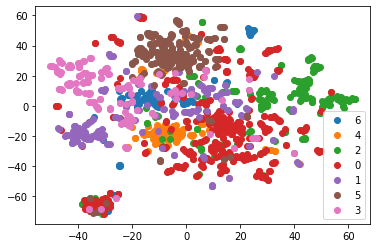

In [4]:
# Get embedding 128 dimension
walks_deepwalk = deepwalk_walks(G, walk_length=10, num_walks=80)
embeddings_deepwalk = get_embedding(G,walks_deepwalk)
plot_embeddings(embeddings_deepwalk, labelfile)


Learning embedding vectors...
Learning embedding vectors done!


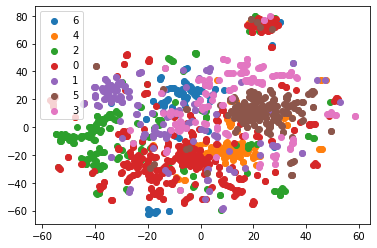

In [5]:
walks_node2vec = node2vec_walks(G, p=0.25,q=2, walk_length=10, num_walks=80)
embeddings_node2vec = get_embedding(G,walks_node2vec)
plot_embeddings(embeddings_node2vec, labelfile)


In [8]:
# Evaluate node classification from embedding 
node_classification(embeddings_deepwalk, labelfile)

Training classifier using 5.00% nodes...
-------------------
{'acc': 0.6472416472416472}
-------------------
Training classifier using 10.00% nodes...
-------------------
{'acc': 0.6866283839212469}
-------------------
Training classifier using 20.00% nodes...
-------------------
{'acc': 0.731549815498155}
-------------------
Training classifier using 30.00% nodes...
-------------------
{'acc': 0.7689873417721519}
-------------------
Training classifier using 40.00% nodes...
-------------------
{'acc': 0.7687576875768758}
-------------------
Training classifier using 50.00% nodes...
-------------------
{'acc': 0.7813884785819794}
-------------------
Training classifier using 60.00% nodes...
-------------------
{'acc': 0.7841328413284133}
-------------------
Training classifier using 70.00% nodes...
-------------------
{'acc': 0.7960687960687961}
-------------------
Training classifier using 80.00% nodes...
-------------------
{'acc': 0.7859778597785978}
-------------------


Number of clusters:  2   Modularity:  0.02801601189836017
Number of clusters:  3   Modularity:  0.31053946249749265
Number of clusters:  4   Modularity:  0.584319706113489
Number of clusters:  5   Modularity:  0.6319994260747027
Number of clusters:  6   Modularity:  0.7153918881682794
Number of clusters:  7   Modularity:  0.721534016022524
Number of clusters:  8   Modularity:  0.7458571338110349
Number of clusters:  9   Modularity:  0.7573355859099544
Number of clusters:  10   Modularity:  0.7594590879713903
Number of clusters:  11   Modularity:  0.7638475631723465
Number of clusters:  12   Modularity:  0.7652422432854546
Number of clusters:  13   Modularity:  0.759472567390274
Number of clusters:  14   Modularity:  0.7841987574955263
Number of clusters:  15   Modularity:  0.782743931533311
Number of clusters:  16   Modularity:  0.7570851846145519
Number of clusters:  17   Modularity:  0.7744856605547046
Number of clusters:  18   Modularity:  0.7749493094876011
Number of clusters:  19 

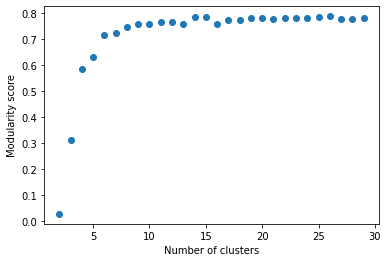

In [9]:
# need undirected graphs for modularity computation 
G1 = G.to_undirected()
# converting node labes to integers for indexing in modularity computation 
G1 = nx.relabel_nodes(G1, lambda x: int(x)-1)
cluster_eval(G1, embeddings_deepwalk)

In [10]:
makeLinkPredictionData(G1, embeddings_deepwalk) 

Link predictions: 0.05 :Accuracy: 0.5859008874264633
Link predictions: 0.1 :Accuracy: 0.5702557625513104
Link predictions: 0.2 :Accuracy: 0.5731201894612197
Link predictions: 0.3 :Accuracy: 0.5791610284167794
Link predictions: 0.4 :Accuracy: 0.5639406378275971
Link predictions: 0.5 :Accuracy: 0.5636604774535809
Link predictions: 0.6 :Accuracy: 0.5754203173099692
Link predictions: 0.7 :Accuracy: 0.5778339122197663
Link predictions: 0.8 :Accuracy: 0.5767045454545454
